In [ ]:
!pip install rouge-score langchain_community faiss-cpu pypdf mlflow

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.4/27.4 MB 56.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 kB 25.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 623.0/623.0 kB 34.4 MB/s eta 0:00:00
   ━━━━

In [ ]:

from google.colab import userdata
import os
os.environ["HUGGINGFACEHUB_API_TOKEN"]=userdata.get('HF_TOKEN')


In [ ]:
questions = [
    "What is a fracture and what are its main types?",
    "Explain the mechanism of fracture healing.",
    "What are the clinical features of fractures?",
    "What are the principles of fracture treatment?",
    "Describe the types of internal fixation methods.",
    "What are the complications of open fractures?",
    "Explain the classification of fractures.",
    "What are the indications for ORIF (Open Reduction Internal Fixation)?",
    "What are the complications of internal fixation?",
    "What is external fixation and its applications?"
]

reference_answers = [
    "A fracture is a loss of continuity of bone. Main types include:\n- Simple (closed) fractures\n- Compound (open) fractures\n- Hairline fractures\n- Comminuted fractures\n- Complete and incomplete fractures",
    "Fracture healing occurs through several stages:\n1. Hematoma formation\n2. Inflammatory phase\n3. Callus formation\n4. Consolidation\n5. Remodeling\nThis process can occur through primary or secondary healing patterns.",
    "Clinical features of fractures include:\n1. Pain and tenderness\n2. Swelling\n3. Deformity\n4. Crepitus\n5. Loss of function\n6. Abnormal movement\n7. Neurovascular injuries\nDiagnosis is confirmed through clinical picture and radiography.",
    "Key principles of fracture treatment include:\n1. Anatomical reduction\n2. Stable internal fixation\n3. Preservation of blood supply\n4. Early mobilization\n5. Treatment of the patient, not just the fracture\n6. Restriction of movement\n7. Prevention of displacement",
    "Internal fixation methods include:\n1. Pin and wire fixation\n2. Screw fixation\n3. Plate and screw fixation\n4. Intramedullary nail fixation\nEach method has specific applications based on fracture type and location.",
    "Complications of open fractures include:\n1. Infection risk (varies by type)\n2. Soft tissue damage\n3. Compartment syndrome\n4. Delayed union\n5. Non-union\n6. Vascular compromise\nPrevention involves prompt debridement, antibiotics, and proper stabilization.",
    "Fractures are classified according to:\n1. Plane of fracture surface\n2. Cause (traumatic/pathological/stress)\n3. Number (single/multiple)\n4. Completeness\n5. Mechanism of injury (spiral/oblique/transverse)",
    "ORIF indications include:\n1. Absolute: Unable to obtain adequate reduction, displaced intra-articular fractures, certain epiphyseal fractures\n2. Relative: Delayed unions, multiple fractures, pathological fractures\n3. To assist in nursing care and reduce morbidity",
    "Internal fixation complications include:\n1. Infection (leading cause of chronic osteomyelitis)\n2. Non-union due to poor technique\n3. Implant failure\n4. Refracture\n5. Soft tissue damage\nMost complications result from poor technique or conditions.",
    "External fixation is a method using external frames and pins to stabilize fractures. Applications include:\n1. Open fractures\n2. Pelvic fractures\n3. Severe soft tissue damage\n4. Comminuted unstable fractures\n5. Cases with neurovascular damage\nAllows adjustment of length and angulation during healing."
]


In [ ]:

from langchain_community.document_loaders import PyPDFLoader
from langchain_community.document_loaders import PyPDFDirectoryLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceBgeEmbeddings
from langchain.chains import RetrievalQA
from langchain_community.llms import HuggingFaceHub

llm = HuggingFaceHub(
        repo_id="mistralai/Mistral-7B-v0.1",
        model_kwargs={
            "temperature": 0.1,
            "max_length": 2000
        }
    )


EMBEDDING_MODEL_NAME: str = "BAAI/bge-small-en-v1.5"
EMBEDDING_PATH: str = "misc/embeddings/"
MODEL_KWARGS: dict = {'device': 'cpu'}
ENCODE_KWARGS: dict = {'normalize_embeddings': True}

file="./General principles of fractures treatment 1.pdf"
loader = PyPDFLoader(file)
documents = loader.load()
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
final_documents = text_splitter.split_documents(documents)

huggingface_embeddings = HuggingFaceBgeEmbeddings(
        model_name=EMBEDDING_MODEL_NAME,
        model_kwargs=MODEL_KWARGS,
        encode_kwargs=ENCODE_KWARGS
    )
data = FAISS.from_documents(final_documents, huggingface_embeddings)

qa = RetrievalQA.from_chain_type(
    llm=llm,
    chain_type="stuff",
    retriever=data.as_retriever(),
    return_source_documents=True,
)


<ipython-input-6-3535d15aa9d6>:9: LangChainDeprecationWarning: The class `HuggingFaceHub` was deprecated in LangChain 0.0.21 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEndpoint``.
  llm = HuggingFaceHub(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/94.8k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
answers=[]
for question in questions:
  answers.append(qa({"query": question})['result'].replace("\n","").replace("\uf097",""))

In [ ]:
answers[0]

"Use the following pieces of context to answer the question at the end. If you don't know the answer, just say that you don't know, don't try to make up an answer.Classification of fracture  According plane of # surface  Simple – closed Compound –o p e n  According to cause traumatic pathological stress or fatigue fracture  According to number Single Multiple  Complete #, incomplete#Stress fracture : Bone, like other materials, reacts to repeated loading. On occasion, it becomes fatigued & a crack develops e.g military installations, ballet dancers & athletes.Principles of fractures \uf09eFracture repair is a tissue regeneration process rather than a healing process the injured bone is replaced by bone. \uf09eThe process of repair varies according to: ‐The type of bone involved. ‐The amount of movement at the fracture. ‐The closeness of the fracture surfaces.OPEN AND CLOSED FRACTURESQuestion: What is a fracture and what are its main types?Helpful Answer: A fracture is a break in a bone

# ROUGE score
1. ROUGE-N Measures the overlap of n-grams (contiguous sequences of n items) between the candidate and reference text.
2. ROUGE-L Measures the Longest Common Subsequence (LCS) between the candidate and reference text. It captures sentence-level structure similarity.
3. ROUGE-W
Definition: A weighted variant of ROUGE-L, emphasizing consecutive matches more than non-consecutive ones.
4. ROUGE-S (Skip-Bigram)
Definition: Measures the overlap of skip-bigrams, which are pairs of words that appear in the same order but are not necessarily adjacent.

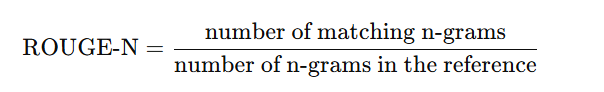

In [ ]:
from rouge_score import rouge_scorer

scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
scores = scorer.score('He is running fast to catch the bus',
                      'He runs quickly to catch the bus.')
print(score)

0.703125


In [ ]:
scorer = rouge_scorer.RougeScorer(['rouge1', 'rougeL'], use_stemmer=True)
for reference_answer, answer in zip(reference_answers, answers):
    print(scorer.score(reference_answer.replace('\n', ''),answer))

{'rouge1': Score(precision=0.09502262443438914, recall=0.8076923076923077, fmeasure=0.1700404858299595), 'rougeL': Score(precision=0.07239819004524888, recall=0.6153846153846154, fmeasure=0.12955465587044535)}
{'rouge1': Score(precision=0.017777777777777778, recall=0.16666666666666666, fmeasure=0.0321285140562249), 'rougeL': Score(precision=0.017777777777777778, recall=0.16666666666666666, fmeasure=0.0321285140562249)}
{'rouge1': Score(precision=0.0736196319018405, recall=0.46153846153846156, fmeasure=0.12698412698412698), 'rougeL': Score(precision=0.06748466257668712, recall=0.4230769230769231, fmeasure=0.1164021164021164)}
{'rouge1': Score(precision=0.07905138339920949, recall=0.625, fmeasure=0.14035087719298245), 'rougeL': Score(precision=0.07114624505928854, recall=0.5625, fmeasure=0.12631578947368421)}
{'rouge1': Score(precision=0.09826589595375723, recall=0.6071428571428571, fmeasure=0.1691542288557214), 'rougeL': Score(precision=0.08670520231213873, recall=0.5357142857142857, fm

## BLEU
(Bilingual Evaluation Understudy) is a metric used for evaluating the quality of text generation, especially in machine translation. It measures how closely the generated text matches one or more reference texts by comparing n-grams. BLEU values range from 0 to 1, where 1 indicates a perfect match.

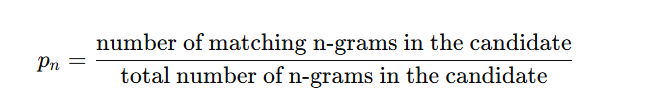

brevity penalty

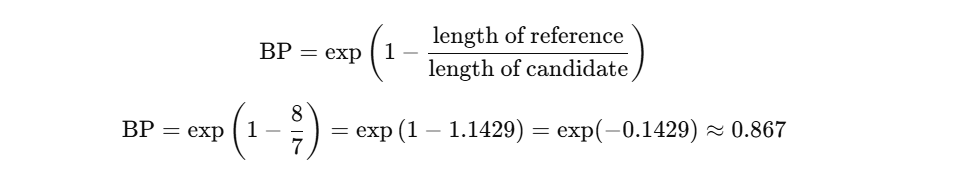



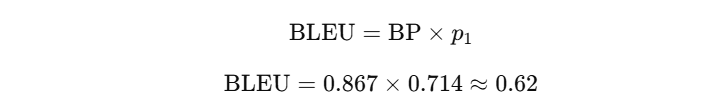

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from nltk.tokenize import word_tokenize


candidate = word_tokenize("He runs quickly to catch the bus")
reference = [word_tokenize("He is running fast to catch the bus")]

score = sentence_bleu(reference, candidate,weights=(1, 0, 0, 0))
print(f"BLEU score: {score}")

BLEU score: 0.6191984998215584


In [ ]:
for  referance_answer, answer in zip(reference_answers,answers):
  print(sentence_bleu([word_tokenize(reference_answer.replace("\n"," "))],word_tokenize(answer),weights=(1, 0, 0, 0)))
  print("-----------------------------------")

0.06504065040650409
-----------------------------------
0.07172995780590716
-----------------------------------
0.11458333333333331
-----------------------------------
0.07169811320754717
-----------------------------------
0.09278350515463919
-----------------------------------
0.06703910614525141
-----------------------------------
0.07070707070707069
-----------------------------------
0.05791505791505791
-----------------------------------
0.05555555555555554
-----------------------------------
0.12145748987854249
-----------------------------------


#METEOR   
(Metric for Evaluation of Translation with Explicit ORdering) metric is a popular evaluation metric in natural language processing (NLP), particularly for machine translation, summarization, and other text generation tasks. Unlike BLEU, METEOR considers synonyms, stemming, and word order, making it more semantically sensitive.*italicised text*

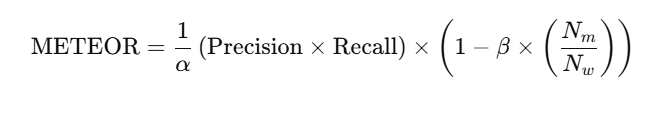

In [ ]:
import nltk
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
import nltk
#nltk.download('wordnet')

# Candidate and Reference Texts
reference = [word_tokenize("He is running fast to catch the bus")]
candidate = word_tokenize("He runs quickly to catch the bus.")

# Calculate METEOR Score
score = meteor_score(reference, candidate)
print(f"METEOR Score: {score}")


METEOR Score: 0.703125


In [ ]:
import nltk
from nltk.translate.meteor_score import meteor_score
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet as wn
from nltk.stem import PorterStemmer
import nltk

# Download necessary resources
nltk.download('punkt')
nltk.download('wordnet')

# Initialize stemmer
stemmer = PorterStemmer()

# Function to check if two words are synonyms using WordNet
def are_synonyms(word1, word2):
    synsets1 = wn.synsets(word1)
    synsets2 = wn.synsets(word2)
    for syn1 in synsets1:
        for syn2 in synsets2:
            if syn1.wup_similarity(syn2) and syn1.wup_similarity(syn2) > 0.9:
                return True
    return False

# Function to calculate precision
def precision(reference, candidate):
    ref_set = set(reference)
    cand_set = set(candidate)
    return len(ref_set.intersection(cand_set)) / len(cand_set) if len(cand_set) > 0 else 0

# Function to calculate recall
def recall(reference, candidate):
    ref_set = set(reference)
    cand_set = set(candidate)
    return len(ref_set.intersection(cand_set)) / len(ref_set) if len(ref_set) > 0 else 0

# Candidate and Reference Texts
reference = word_tokenize("He is running fast to catch the bus.")
candidate = word_tokenize("He runs quickly to catch the bus.")

# Stemming process
stemmed_reference = [stemmer.stem(word) for word in reference]
stemmed_candidate = [stemmer.stem(word) for word in candidate]

# Synonym matching process
synonym_matched = 0
for ref_word in reference:
    for cand_word in candidate:
        if are_synonyms(ref_word, cand_word):
            synonym_matched += 1

# Calculate METEOR Score
meteor = meteor_score([reference], candidate)

# Calculate Precision and Recall
prec = precision(reference, candidate)
rec = recall(reference, candidate)

# Results
print(f"METEOR Score: {meteor}")
print(f"Precision: {prec}")
print(f"Recall: {rec}")
print(f"Synonym Matches: {synonym_matched}")


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


METEOR Score: 0.755560651226783
Precision: 0.75
Recall: 0.6666666666666666
Synonym Matches: 4
